# Text Clustering Basics

This snippet shows how to use the algorithm mini batch k-means to cluster text. In this example we use the newsgroup dataset from scikit-learn. There are multiple categories in the newsgroup dataset, but we will only use the documents categories 'talk.politics.misc', 'talk.religion.misc' and 'talk.politics.guns'.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import cluster, datasets, manifold, utils, preprocessing, decomposition, pipeline, metrics
from sklearn.feature_extraction import text

To simplyfy our example we are only interested in the documents categories politics, religion and guns. The other categories are ignored in our example.

In [2]:
categories = ['talk.politics.misc', 'talk.religion.misc', 'talk.politics.guns']
dataset = datasets.fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=False, random_state=42, download_if_missing=True)

print(dataset.target_names)

['talk.politics.guns', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

2313 documents
3 categories


We build a bag of words model with the TF-IDF vectorizer, which converts the words from the text documents to features.  In our case we use words as features, but you could also use character n-grams as features. There are plenty of options to tune your model like min / max document frequency, max features, stopwords, etc. All this options have an impact which features are used in the final model.

In [4]:
vectorizer = text.TfidfVectorizer(analyzer='word', max_df=0.8, max_features=1000,
                                 min_df=2, stop_words='english',
                                 use_idf=True)
X = vectorizer.fit_transform(dataset.data)
print(X.shape)

(2313, 1000)


We have now 2313 samples with 1000 features, which is a high dimensional datasets. So we can now use latent semantic analysis to reduce dimensionality and discover latent patterns in the data.

In [5]:
svd = decomposition.TruncatedSVD(n_components=2)
normalizer = preprocessing.Normalizer(copy=False, norm='l2')
lsa = pipeline.make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

Next use the k-means mini batch algorithm to cluster documents in the new created two-dimensional space.  

In [6]:
n_clusters = 3
kmeans = cluster.MiniBatchKMeans(n_clusters=n_clusters, random_state=1)
label = kmeans.fit_predict(X)

df = pd.DataFrame(X, columns=['X', 'Y'])
df['label'] = label

Fortunately we have the true clusters and can evaluate our model against them. A first step to evaluate the model is to plot the true and predicted clusters scatter plot in a two dimensional space.

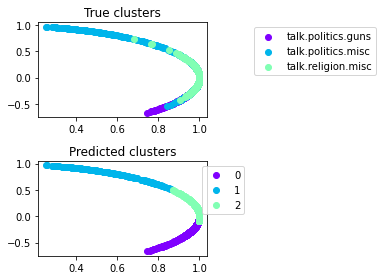

In [7]:
fig = plt.figure()
colors = [cm.rainbow(i/(n_clusters + 1)) for i in range(n_clusters)]

ax = fig.add_subplot(211)
for i in range(len(dataset.target_names)):
    plt.scatter(df[dataset.target == i].X, df[dataset.target == i].Y, color=colors[i], label=dataset.target_names[i])

ax.set_title('True clusters')
plt.legend(bbox_to_anchor=(1.25, 1))

ax = fig.add_subplot(212)
for i in range(n_clusters):
    plt.scatter(df[df.label == i].X, df[df.label == i].Y, color=colors[i], label=i)
    

ax.set_title('Predicted clusters')
plt.legend(bbox_to_anchor=(1.25, 1))

fig.tight_layout()

We can see in the plot that the predicted and true clusters differ a lot. When we look at the different metrics the score is very low as well. The true clusters cannot easily be separated with our approach, because some documents categories are overlapping as you can see in the true cluster section of the scatter plot. With the k-means approach a centroid is set and the nearest documents are assigned to that clusters. As you can see with this approach we have no overlapping documents, which explains the low metric score.

In [8]:
metrics.adjusted_rand_score(dataset.target, label)

0.19426607383020106

In [9]:
metrics.adjusted_mutual_info_score(dataset.target, label)

0.2135890338083402

In [10]:
metrics.accuracy_score(dataset.target, label)

0.5905750108084739